# Importation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import yaml
 
from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel
from qubic.lib.Qsamplings import get_pointing, equ2gal, QubicSampling
from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene

from qubic.lib.MapMaking.Qcg_test_for_atm import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockDiagonalOperator, BlockRowOperator, DiagonalOperator, ReshapeOperator, Rotation3dOperator, Spherical2CartesianOperator, Cartesian2SphericalOperator

from pysimulators.interfaces.healpy import Spherical2HealpixOperator, HealpixConvolutionGaussianOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank() 

%matplotlib inline

In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 
    
np.random.seed(params['seed'])

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

# Scanning Strategy

## Galactic Coordinates

In [4]:
### Random pointing
qubic_dict['random_pointing'] = True
qubic_dict['date_obs'] = '2016-01-01T00:00:00'

### Sweepingpointing
qubic_dict['sweeping_pointing'] = False
qubic_dict['fix_azimuth']['apply'] = False 

# qubic_dict['angspeed'] = 0.4
# qubic_dict['delta_az'] = 20
# qubic_dict['nsweeps_per_elevation'] = 5
# qubic_dict['period'] = 1e-15
# qubic_dict['duration'] = 1
# npointings = 3600 * t_obs / period

### Repeat pointing
qubic_dict['repeat_pointing'] = False

qubic_dict['fix_azimuth']['apply'] = False

q_sampling_gal = get_pointing(qubic_dict)
qubic_patch = np.array([0, -57])
center_gal = equ2gal(qubic_patch[0], qubic_patch[1])
center_local = np.array([np.mean(q_sampling_gal.azimuth), np.mean(q_sampling_gal.elevation)])
print(q_sampling_gal)

QubicSampling((10000,), 
    index=[   0    1    2 ... 9997 9998 9999],
    angle_hwp=[60 60 45 ... 60 60 45],
    azimuth=[215.69991503 202.97188267 220.77544415 ... 200.37893899 220.9377,
    elevation=[39.38626833 56.65787068 37.66592413 ... 31.5482579  14.37329619
,
    equatorial=[[339.12721381 -56.35764262]
 [ 12.48898913 -53.50100626]
 [334.7,
    galactic=[[333.0263752  -52.15383358]
 [303.42799553 -63.62581628]
 [340.0,
    masked=False,
    pitch=[290.08873307 194.97146669 316.39923231 ... 152.80530101 349.2810)


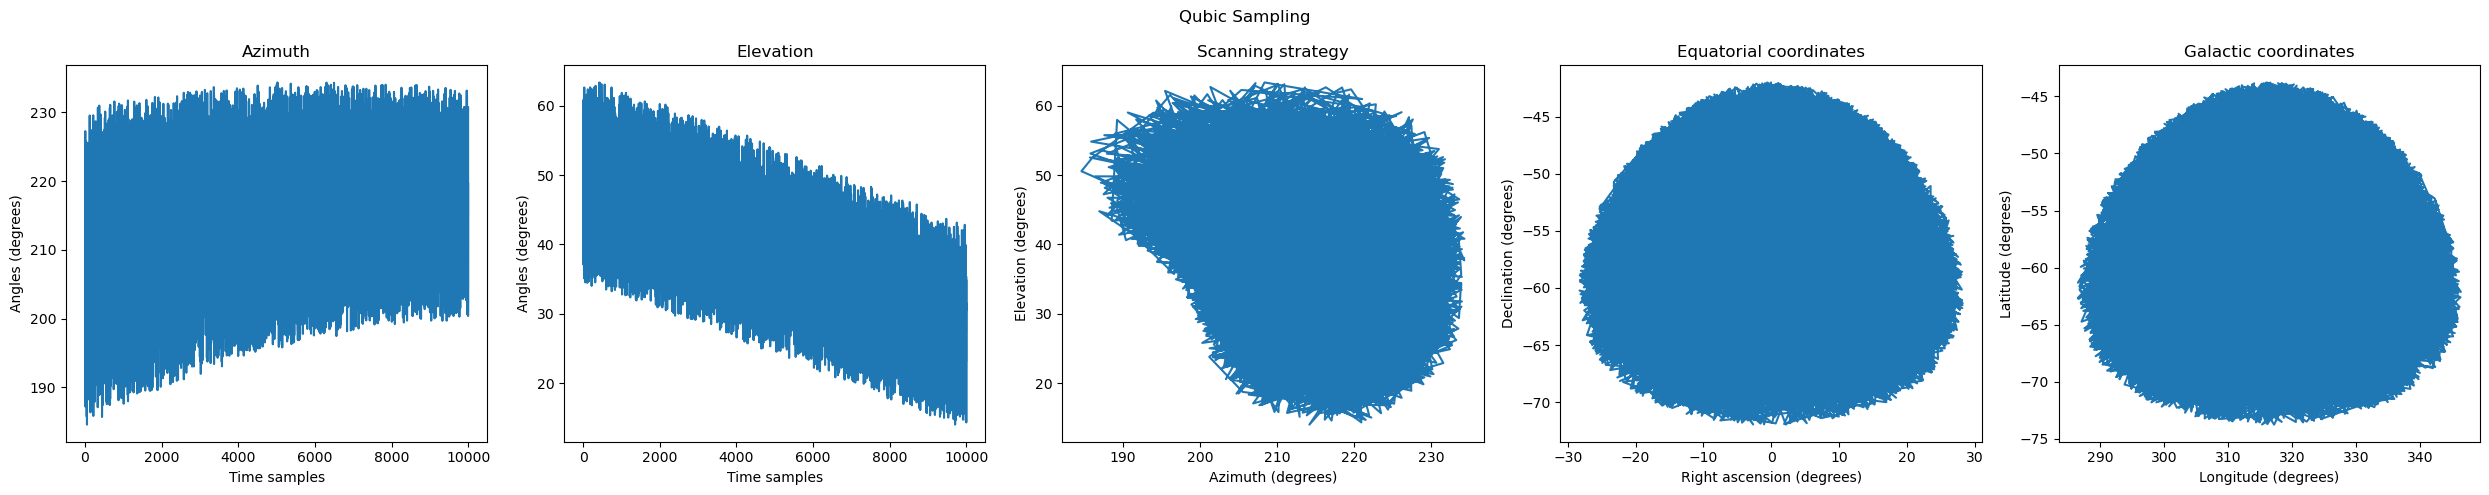

In [5]:
az, el = q_sampling_gal.azimuth, q_sampling_gal.elevation

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# Azimuth plot
axs[0].plot(az)
axs[0].set_title("Azimuth")
axs[0].set_xlabel("Time samples")
axs[0].set_ylabel("Angles (degrees)")

# Elevation plot
axs[1].plot(el)
axs[1].set_title("Elevation")
axs[1].set_xlabel("Time samples")
axs[1].set_ylabel("Angles (degrees)")

# Scanning strategy plot
axs[2].plot(az, el)
axs[2].set_title("Scanning strategy")
axs[2].set_xlabel("Azimuth (degrees)")
axs[2].set_ylabel("Elevation (degrees)")

# Equatorial coordinates plot
axs[3].plot((q_sampling_gal.equatorial[:, 0] + 180) % 360 - 180, q_sampling_gal.equatorial[:, 1])
axs[3].set_title("Equatorial coordinates")
axs[3].set_xlabel("Right ascension (degrees)")
axs[3].set_ylabel("Declination (degrees)")

# Galactic coordinates plot
axs[4].plot(q_sampling_gal.galactic[:, 0], q_sampling_gal.galactic[:, 1])
axs[4].set_title("Galactic coordinates")
axs[4].set_xlabel("Longitude (degrees)")
axs[4].set_ylabel("Latitude (degrees)")

fig.suptitle("Qubic Sampling")
plt.tight_layout()
plt.show()

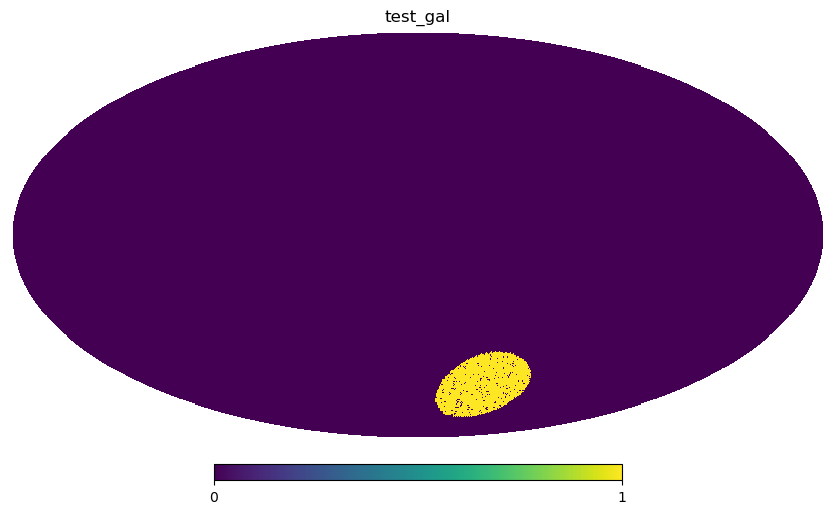

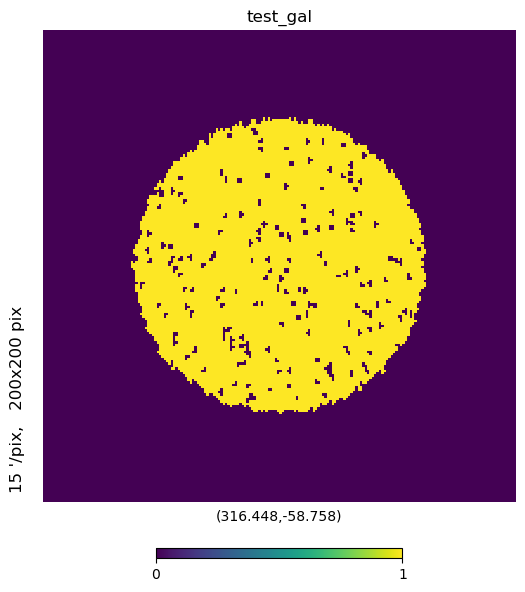

In [6]:
test_gal = np.zeros(hp.nside2npix(params['nside']))

index = np.array(Spherical2HealpixOperator(params['nside'], 'azimuth, elevation')(np.radians(q_sampling_gal.galactic)), dtype='int')
test_gal[index] = 1
hp.mollview(test_gal, title='test_gal', cmap='viridis')
hp.gnomview(test_gal, title='test_gal', cmap='viridis', reso=15, rot=center_gal)

## Local Coordinates

In [7]:
q_sampling_local = QubicSampling(q_sampling_gal.index.size, #int(np.ceil(qubic_dict['duration']*3600/qubic_dict['period'])),
                           date_obs = qubic_dict['date_obs'],
                           period = qubic_dict['period'],
                           latitude = qubic_dict['latitude'],
                           longitude = qubic_dict['longitude'])

q_sampling_local.azimuth = q_sampling_gal.azimuth
q_sampling_local.elevation = q_sampling_gal.elevation
q_sampling_local.pitch = q_sampling_gal.pitch
q_sampling_local.angle_hwp = q_sampling_gal.angle_hwp

q_sampling_local.fix_az = True

213.9673520650736 38.471590677314936


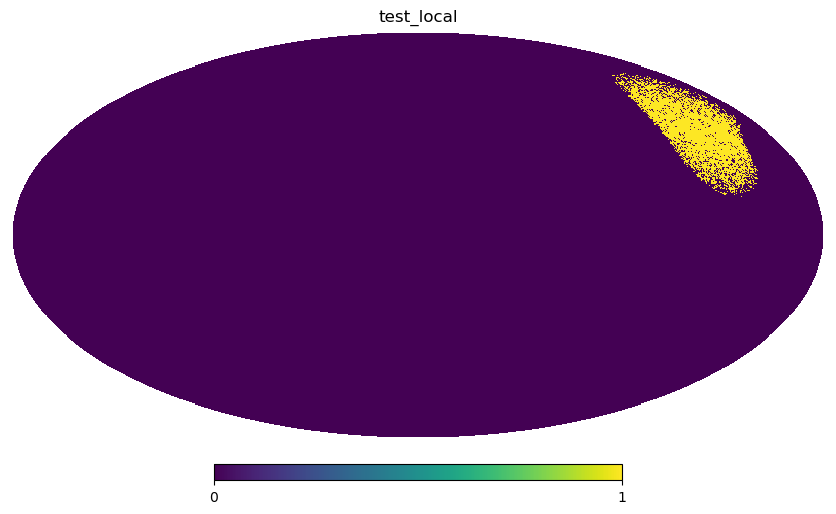

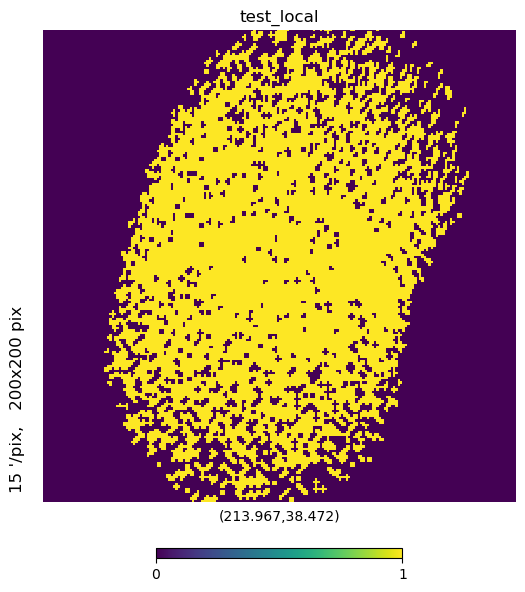

In [8]:
test_gal = np.zeros(hp.nside2npix(params['nside']))

index = np.array(Spherical2HealpixOperator(params['nside'], 'azimuth, elevation')(np.radians([q_sampling_local.azimuth, q_sampling_local.elevation]).T), dtype='int')
test_gal[index] = 1
hp.mollview(test_gal, title='test_local', cmap='viridis')
hp.gnomview(test_gal, title='test_local', cmap='viridis', reso=15, rot=(np.mean(q_sampling_local.azimuth), np.mean(q_sampling_local.elevation)))

print(np.mean(q_sampling_local.azimuth), np.mean(q_sampling_local.elevation))

# Input Maps

## CMB

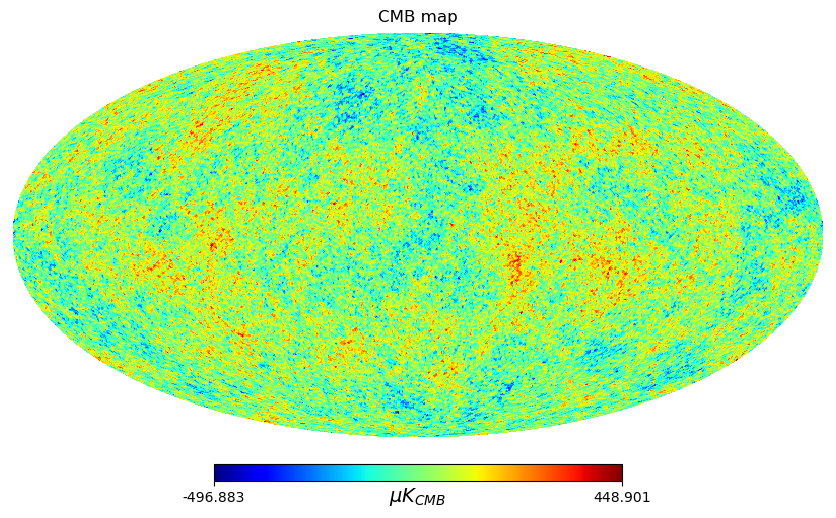

In [9]:
# Build CMB map
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
cmb_map = hp.synfast(cl_cmb, params['nside'], new=True, verbose=False).T

hp.mollview(cmb_map[:, 0], cmap='jet', title='CMB map', unit=r'$µK_{CMB}$')

## Atmosphere

In [10]:
atm_map = np.zeros((cmb_map.shape))

mean_rho = atm.mean_water_vapor_density
atm_map[:, 0] = atm.get_temp_maps(atm.get_water_vapor_density_2d_map(0, flat=False))[0]
atm_map[:, 0] -= np.mean(atm_map[:, 0])

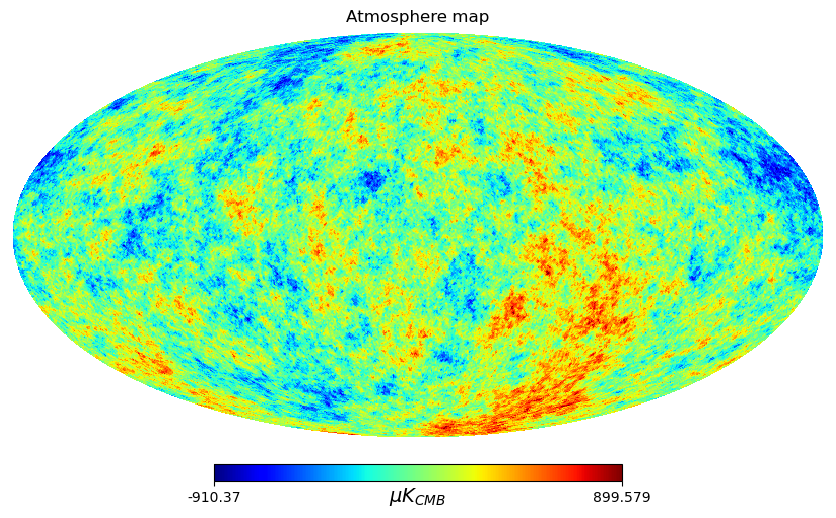

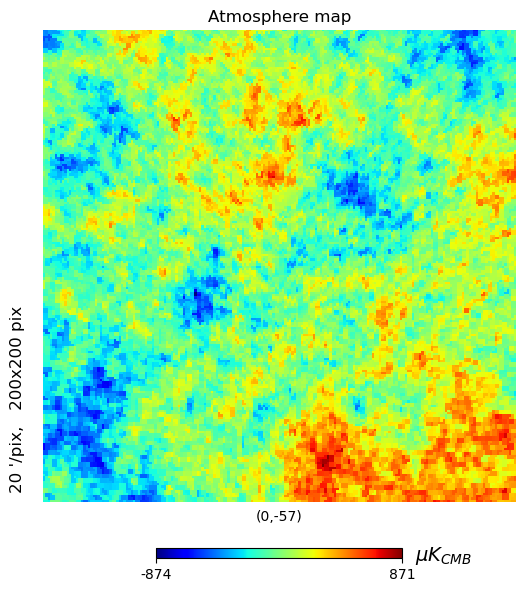

In [11]:
hp.mollview(atm_map[:, 0], cmap='jet', title='Atmosphere map', unit=r'$µK_{CMB}$')
hp.gnomview(atm_map[:, 0], rot=qubic_patch, reso=20, title='Atmosphere map', unit=r'$µK_{CMB}$', cmap='jet')

# Build QUBIC Instances

In [12]:
q_instrument = QubicInstrument(qubic_dict)
q_scene  = QubicScene(qubic_dict)

#! Verify that using the same dictionary is not an issue for the two objects
q_acquisition_local = QubicAcquisition(q_instrument, q_sampling_local, q_scene, qubic_dict)
q_acquisition_gal = QubicAcquisition(q_instrument, q_sampling_gal, q_scene, qubic_dict)

In [13]:
coverage_gal = q_acquisition_gal.get_coverage()
covnorm_gal = coverage_gal / coverage_gal.max()
seenpix_gal = covnorm_gal > params['coverage_cut']
seenpix_gal_wo_cut = covnorm_gal > 0

coverage_local = q_acquisition_local.get_coverage()
covnorm_local = coverage_local / coverage_local.max()
seenpix_local = covnorm_local > params['coverage_cut']
seenpix_local_wo_cut = covnorm_local > 0

seenpix = np.array([seenpix_gal, seenpix_local])

Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.


# Build QUBIC Operaotors

In [14]:
# Convolution operator
C_qubic = HealpixConvolutionGaussianOperator(fwhm=0.0071247)

In [15]:
# Galactic Coordinates

H_gal = q_acquisition_gal.get_operator()
R_gal = ReshapeOperator(H_gal.shapeout, H_gal.shape[0])
invN_gal = R_gal(q_acquisition_gal.get_invntt_operator(False, False)(R_gal.T))
d_gal = H_gal(C_qubic(cmb_map)).ravel()

print("H_gal", H_gal.shapein, H_gal.shapeout)
print("R_gal", R_gal.shapein, R_gal.shapeout)
print("invN_gal", invN_gal.shapein, invN_gal.shapeout)
print("d_gal", d_gal.shape)

Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
H_gal (196608, 3) (992, 10000)
R_gal (992, 10000) (9920000,)
invN_gal (9920000,) (9920000,)
d_gal (9920000,)


In [16]:
# Local Coordinates

H_local = q_acquisition_local.get_operator()
R_local = ReshapeOperator(H_local.shapeout, H_local.shape[0])
invN_local = R_local(q_acquisition_local.get_invntt_operator(False, False)(R_local.T))
d_local = H_local(C_qubic(atm_map)).ravel()

print("H_local", H_local.shapein, H_local.shapeout)
print("R_local", R_local.shapein, R_local.shapeout)
print("invN_local", invN_local.shapein, invN_local.shapeout)
print("d_local", d_local.shape)

Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
H_local (196608, 3) (992, 10000)
R_local (992, 10000) (9920000,)
invN_local (9920000,) (9920000,)
d_local (9920000,)


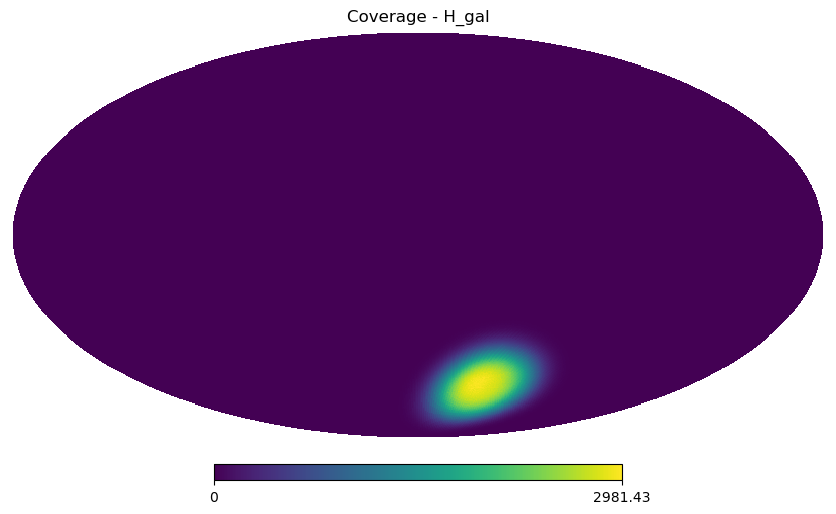

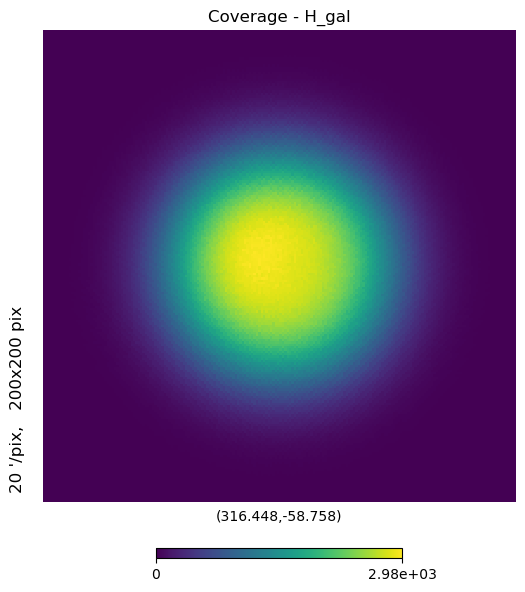

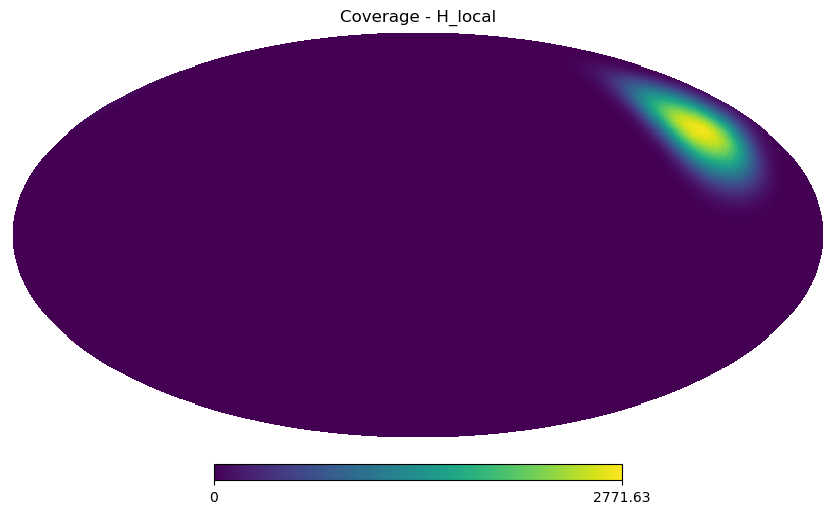

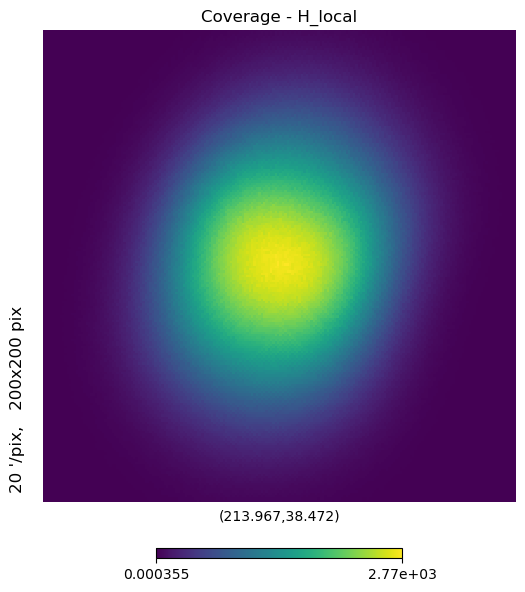

In [17]:
# Plot coverages
hp.mollview(coverage_gal, title='Coverage - H_gal')
hp.gnomview(coverage_gal, title='Coverage - H_gal', rot=center_gal, reso=20)
hp.mollview(coverage_local, title='Coverage - H_local')
hp.gnomview(coverage_local, title='Coverage - H_local', rot=center_local, reso=20)

In [18]:
# Full MM

R = ReshapeOperator((2, hp.nside2npix(params['nside']), 3), (2 * hp.nside2npix(params['nside']), 3))
H = BlockRowOperator([H_gal, H_local], axisin=0) * R

invN = invN_gal

#true_maps = np.array([C_qubic(cmb_map), C_qubic(atm_map)])
R = ReshapeOperator((H.shapeout), (invN_gal.shapein))
H = R * H

true_maps = np.array([C_qubic(cmb_map), C_qubic(atm_map)])
d = d_gal + d_local

In [19]:
print("H", H.shapein, H.shapeout)
print("invN", invN.shapein, invN.shapeout)
print("d", d.shape)
print('True maps', true_maps.shape)

H (2, 196608, 3) (9920000,)
invN (9920000,) (9920000,)
d (9920000,)
True maps (2, 196608, 3)


# Map-Making

In [ ]:
# Ax=b equation to be solve by PCG
A = H.T * invN * H
b = H.T * invN * d

# I start from an atm map for the CMB and from a cmb map for the atmosphere
x0 = true_maps * 0

In [21]:
print("A", A.shapein, A.shapeout)
print("Ax", A(x0).shape)
print("b", b.shape)
print("true_maps", true_maps.shape)

A (2, 196608, 3) (2, 196608, 3)
Ax (2, 196608, 3)
b (2, 196608, 3)
true_maps (2, 196608, 3)


In [22]:
# Build Preconditionner
no_det = 992

stacked_dptdp_inv = np.zeros((true_maps.shape[0],12*params['nside']**2))

### Loop on Maps
for i_maps in range(true_maps.shape[0]):
    ### Extract Operators
    h = H.operands[1].operands[i_maps]
    D = h.operands[1]
    P = h.operands[-1]
    sh = P.matrix.data.index.shape

    ### Compute the map P^t P
    point_per_det = int(sh[0] / no_det)
    mapPtP_perdet_seq = np.zeros((no_det, 12 * params['nside']**2))
    sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
    for det, (start, end) in enumerate(sample_ranges):
        indices = P.matrix.data.index[start:end, :]  
        weights = P.matrix.data.r11[start:end, :]
        flat_indices = indices.ravel()
        flat_weights = weights.ravel()

        mapPitPi = np.zeros(12 * params['nside']**2)
        np.add.at(mapPitPi, flat_indices, flat_weights**2)

        mapPtP_perdet_seq[det, :] = mapPitPi
        
    D_elements = D.data
    D_sq = D_elements**2
    mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
    dptdp = mapPtP_seq_scaled.sum(axis = 0)
    dptdp_inv = 1 / dptdp
    dptdp_inv[np.isinf(dptdp_inv)] = 0.
        
    stacked_dptdp_inv[i_maps] = dptdp_inv

M = BlockDiagonalOperator( \
                    [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
                    new_axisin=0)

In [23]:
# Run PCG

algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=300,
    disp=True,
    M=M,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    result = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    result = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 1.8828e-01 1.38875 [13.79414348  0.94329471  0.91936096 15.03021465  0.68418699  0.8024705 ]
   2: 1.3532e-01 1.26480 [15.91015389  0.90863398  0.89728447 22.88624506  1.13062818  1.08949391]
   3: 5.4294e-02 1.30835 [15.92602439  0.92201407  0.94368719 28.47167787  1.40458219  1.35188289]
   4: 2.9400e-02 1.32285 [15.64015307  0.94574941  0.91245695 32.92668749  1.34730044  1.38183791]
   5: 2.4491e-02 1.27690 [15.36259525  0.80660122  0.79865385 34.43778254  1.23881302  1.26948646]
   6: 1.7548e-02 1.39281 [15.13035892  0.64696666  0.69212605 35.56131764  1.09058817  1.12016608]
   7: 1.3899e-02 1.31516 [14.84610185  0.55356558  0.59657832 36.41232439  0.9108448   0.94096052]
   8: 8.9630e-03 1.32032 [14.816699    0.51372246  0.56641133 37.08139359  0.73188859  0.75239972]
   9: 6.0197e-03 1.29132 [14.62323137  0.41956233  0.45109693 37.7986307   0.61890558  0.60686195]
  10: 5.0008e-03 1.29200 [14.54901496  0.39976236  0.41452449 38.20273094  0.53882128

Text(0, 0.5, 'Convergence')

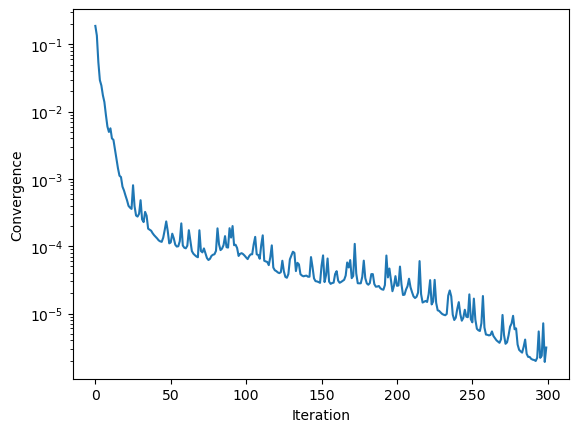

In [24]:
plt.plot(result['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

In [25]:
input = true_maps
output = result['x']
residual = output - input

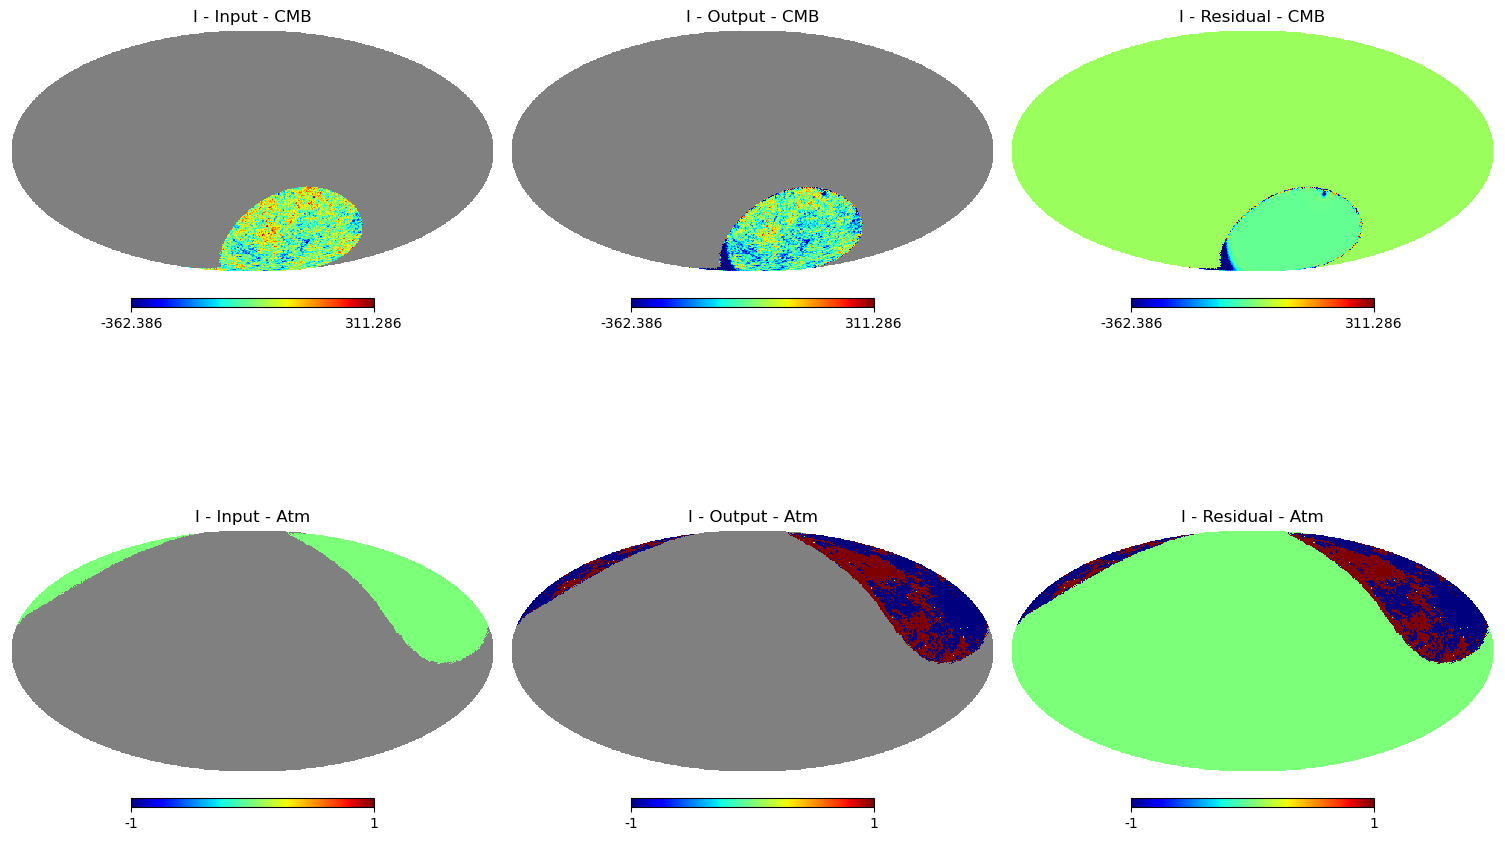

In [26]:
plt.figure(figsize=(15, 10))
k=1

input[0, ~seenpix_gal_wo_cut, :] = hp.UNSEEN
output[0, ~seenpix_gal_wo_cut, :] = hp.UNSEEN
input[1, ~seenpix_local_wo_cut, :] = hp.UNSEEN
output[1, ~seenpix_local_wo_cut, :] = hp.UNSEEN

istk = 0
stk = ['I', 'Q', 'U']
map = ['CMB', 'Atm']

for imap in range(input.shape[0]):
    hp.mollview(input[imap, :, istk],min=np.min(input[imap, seenpix[imap], istk]), max=np.max(input[imap, seenpix[imap], istk]), cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map[imap]}', notext=True)
    hp.mollview(output[imap, :, istk],min=np.min(input[imap, seenpix[imap], istk]), max=np.max(input[imap, seenpix[imap], istk]), cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map[imap]}', notext=True)
    hp.mollview(output[imap, :, istk] - input[imap, :, istk],min=np.min(input[imap, seenpix[imap], istk]), max=np.max(input[imap, seenpix[imap], istk]), cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map[imap]}', notext=True)
    k+=3
    
plt.tight_layout()

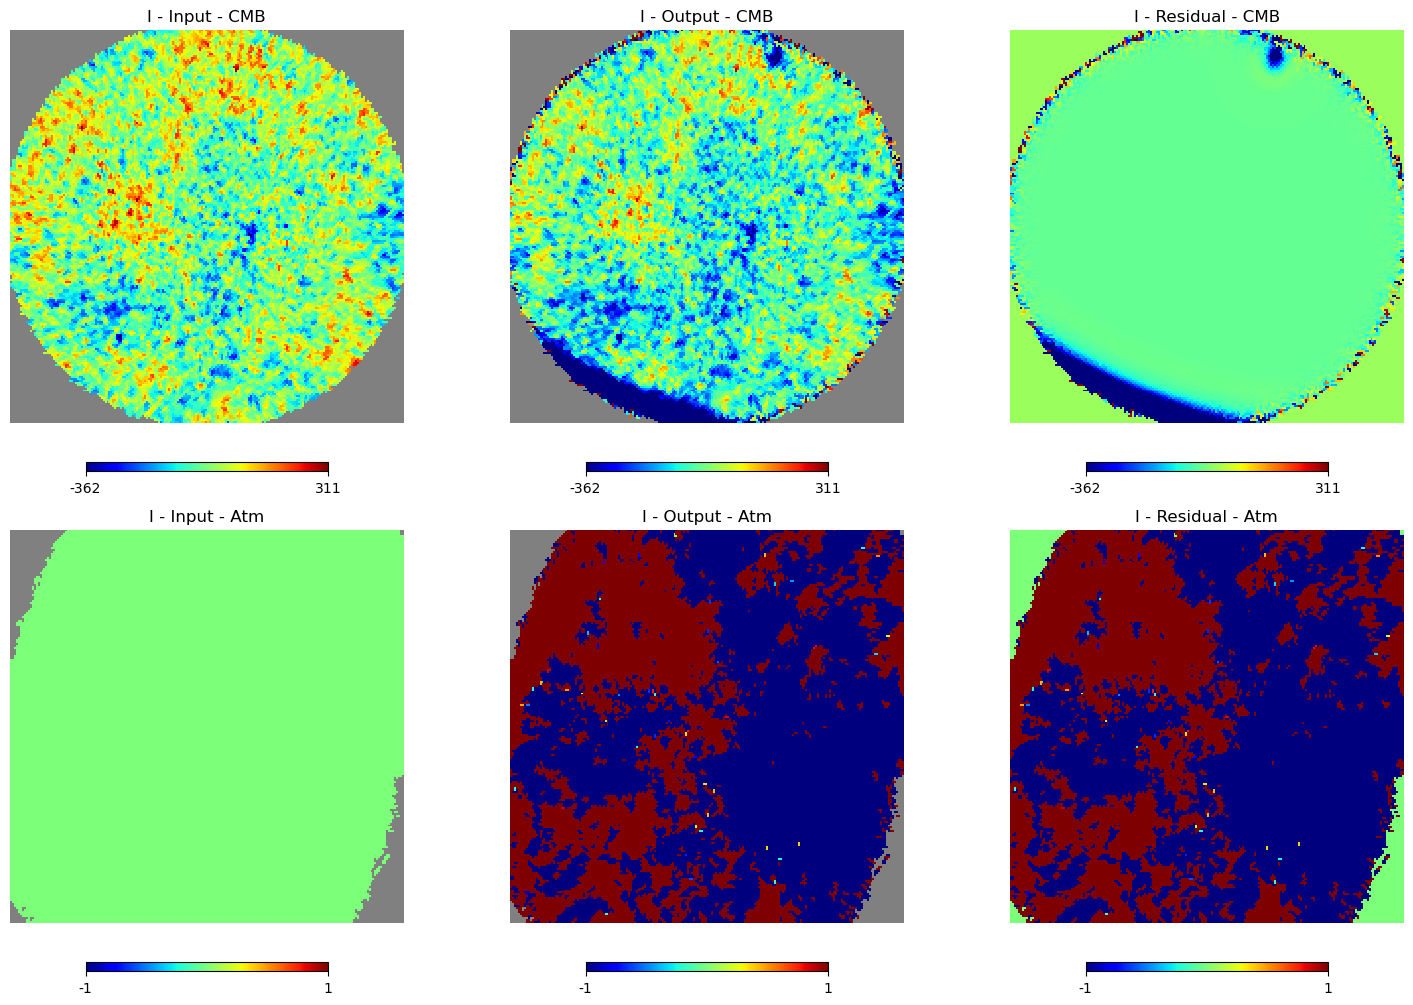

In [27]:
plt.figure(figsize=(15, 10))
k=1

istk = 0

reso = 25
center = [center_gal, center_local]

for imap in range(input.shape[0]):
    hp.gnomview(input[imap, :, istk], min=np.min(input[imap, seenpix[imap], istk]), max=np.max(input[imap, seenpix[imap], istk]), rot=center[imap], reso=reso, cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map[imap]}', notext=True)
    hp.gnomview(output[imap, :, istk], min=np.min(input[imap, seenpix[imap], istk]), max=np.max(input[imap, seenpix[imap], istk]), rot=center[imap], reso=reso, cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map[imap]}', notext=True)
    hp.gnomview(output[imap, :, istk] - input[imap, :, istk], min=np.min(input[imap, seenpix[imap], istk]), max=np.max(input[imap, seenpix[imap], istk]), rot=center[imap], reso=reso, cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map[imap]}', notext=True)
    k+=3
    
plt.tight_layout()

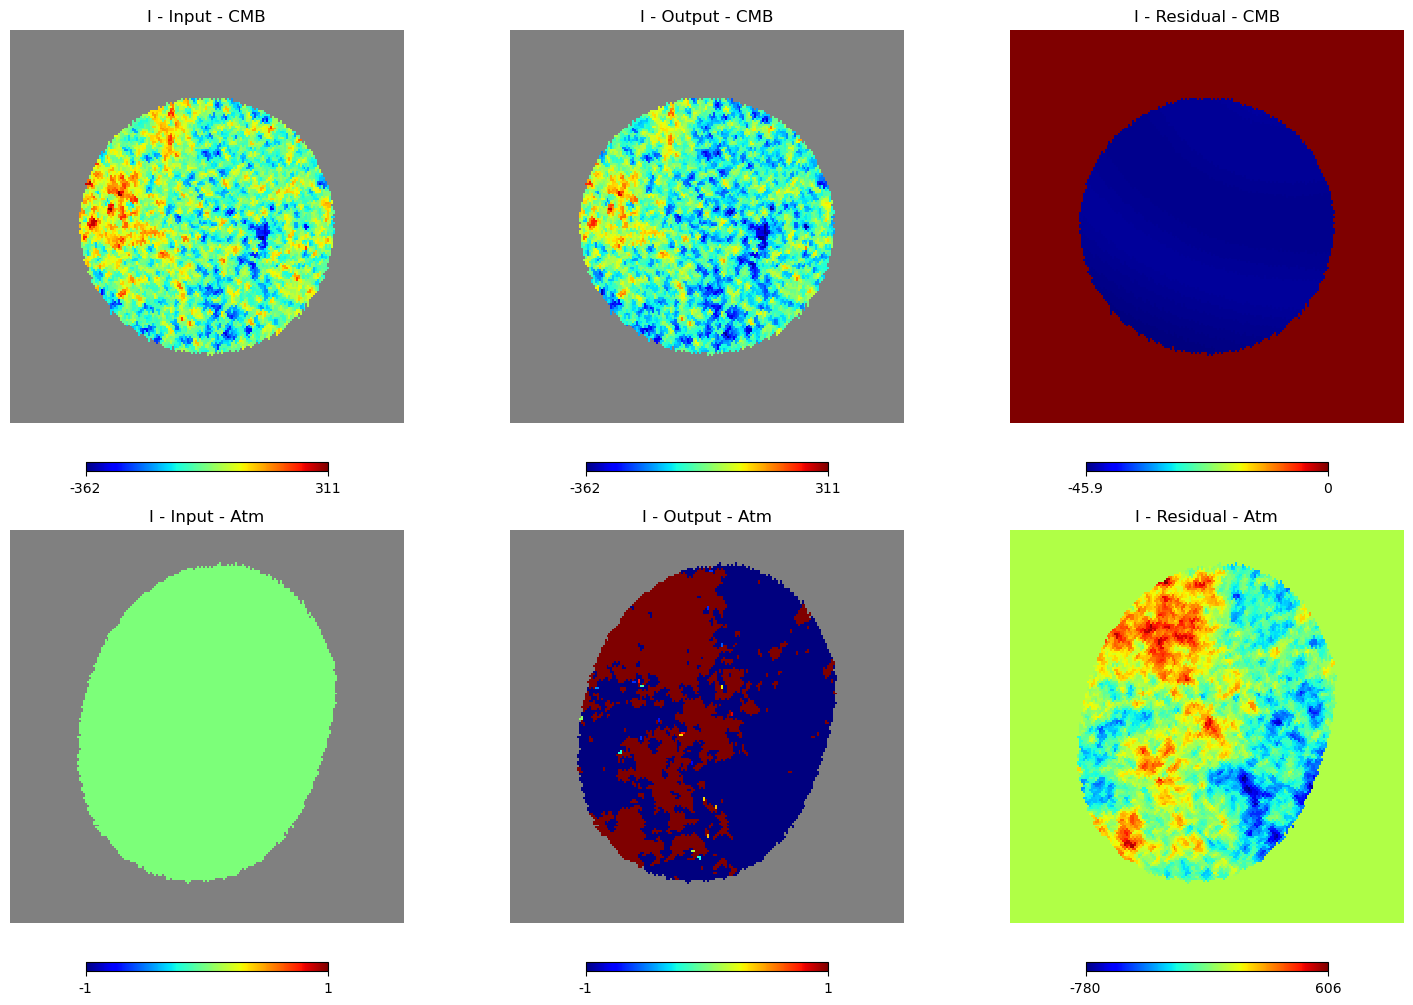

In [28]:
plt.figure(figsize=(15, 10))
k=1

istk = 0

input[0, ~seenpix_gal, :] = hp.UNSEEN
output[0, ~seenpix_gal, :] = hp.UNSEEN
input[1, ~seenpix_local, :] = hp.UNSEEN
output[1, ~seenpix_local, :] = hp.UNSEEN

reso = 20
center = [center_gal, center_local]

for imap in range(input.shape[0]):
    hp.gnomview(input[imap, :, istk], min=np.min(input[imap, seenpix[imap], istk]), max=np.max(input[imap, seenpix[imap], istk]), rot=center[imap], reso=reso, cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map[imap]}', notext=True)
    hp.gnomview(output[imap, :, istk], min=np.min(input[imap, seenpix[imap], istk]), max=np.max(input[imap, seenpix[imap], istk]), rot=center[imap], reso=reso, cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map[imap]}', notext=True)
    hp.gnomview(output[imap, :, istk] - input[imap, :, istk], rot=center[imap], reso=reso, cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map[imap]}', notext=True)
    k+=3
    
plt.tight_layout()

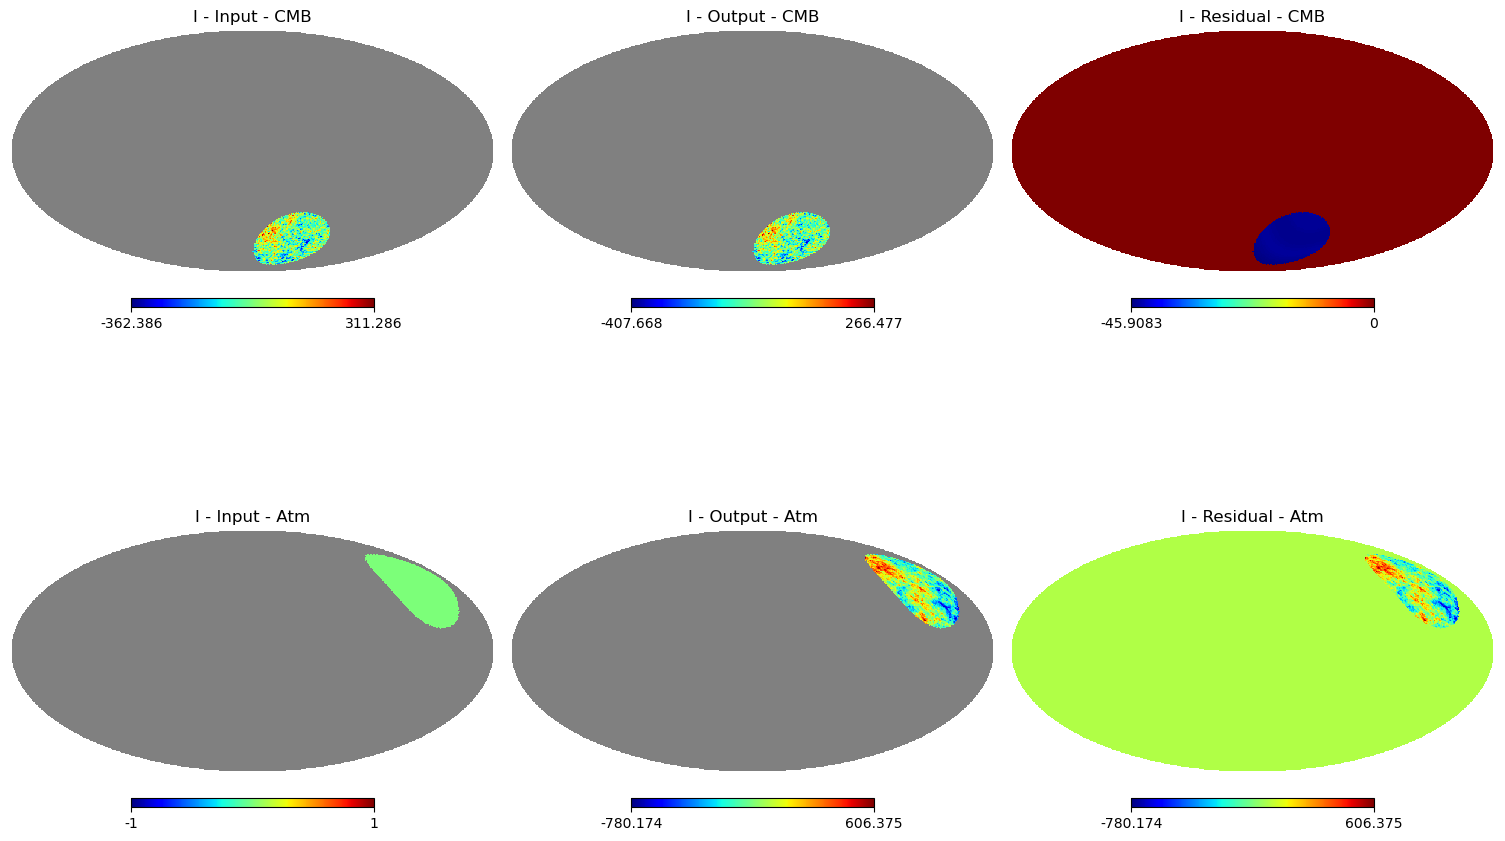

In [29]:
plt.figure(figsize=(15, 10))
k=1

istk = 0

for imap in range(input.shape[0]):
    hp.mollview(input[imap, :, istk], cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map[imap]}', notext=True)
    hp.mollview(output[imap, :, istk], cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map[imap]}', notext=True)
    hp.mollview(output[imap, :, istk] - input[imap, :, istk], cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map[imap]}', notext=True)
    k+=3
    
plt.tight_layout()

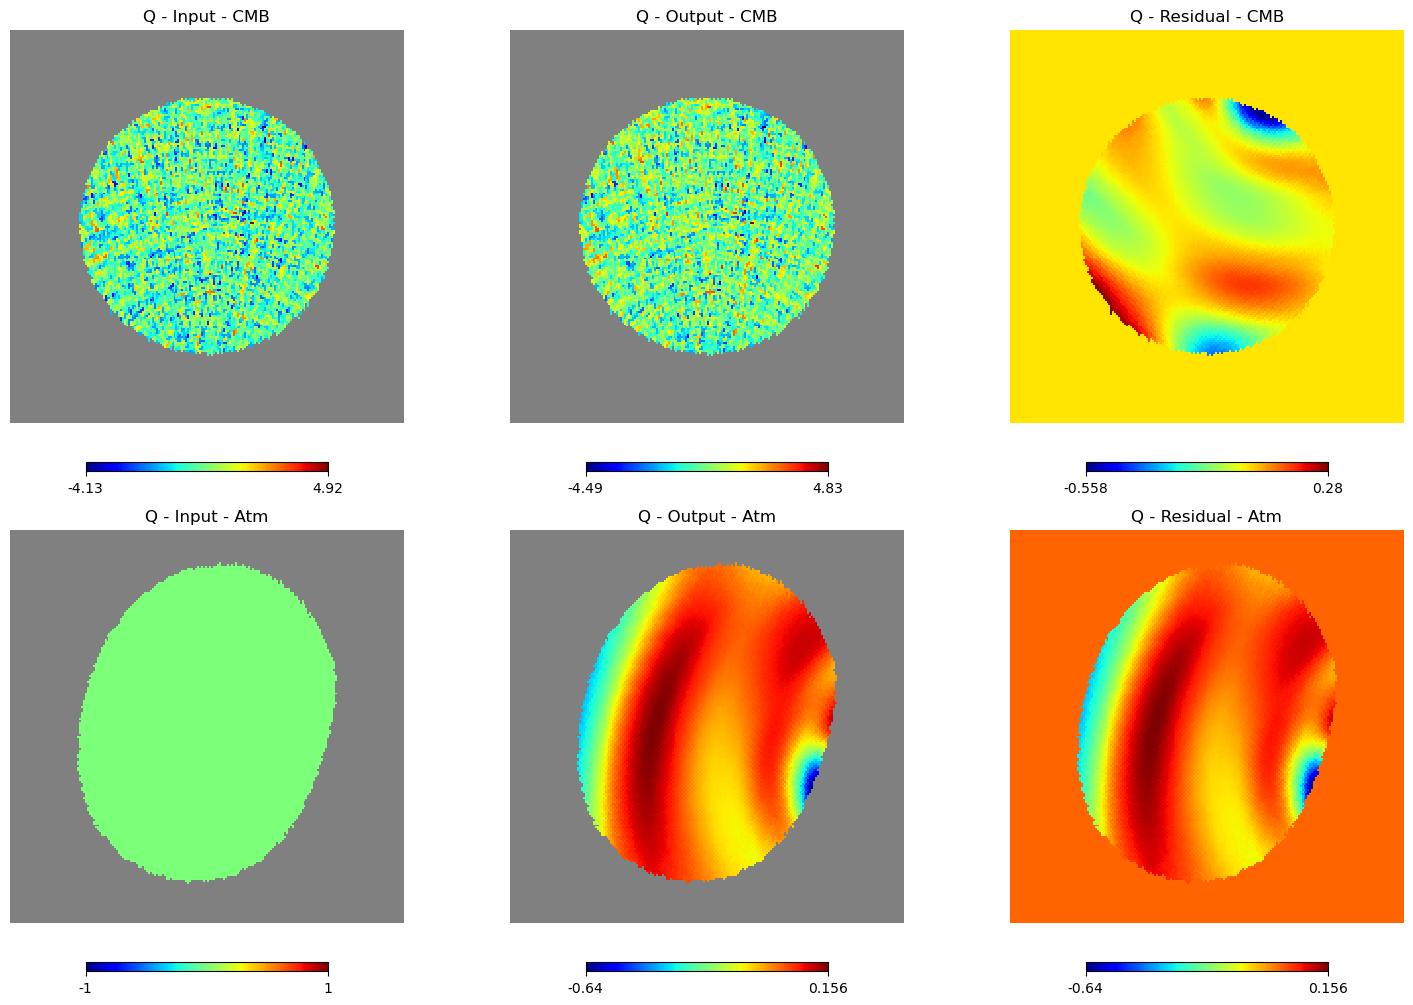

In [30]:
plt.figure(figsize=(15, 10))
k=1

istk = 1

reso = 20
center = [center_gal, center_local]

for imap in range(input.shape[0]):
    hp.gnomview(input[imap, :, istk], rot=center[imap], reso=reso, cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map[imap]}', notext=True)
    hp.gnomview(output[imap, :, istk], rot=center[imap], reso=reso, cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map[imap]}', notext=True)
    hp.gnomview(output[imap, :, istk] - input[imap, :, istk], rot=center[imap], reso=reso, cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map[imap]}', notext=True)
    k+=3
    
plt.tight_layout()